In [1]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [4]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
import tensorflow as tf
import numpy as np

Segmentation Models: using `tf.keras` framework.


In [5]:
def preprocess1(image):
    image_patch_size=256
    size_x=(image.shape[1]//image_patch_size)*image_patch_size
    size_y=(image.shape[0]//image_patch_size)*image_patch_size
    image=Image.fromarray(image)
    image=image.crop((0,0,size_x,size_y))
    image=np.array(image)
    image_patches=patchify(image,(image_patch_size,image_patch_size,3),step=image_patch_size)
    minmaxscaler=MinMaxScaler()
    image_x=image_patches[0,0,:,:]
    image_y=minmaxscaler.fit_transform(image_x.reshape(-1,image_x.shape[-1])).reshape(image_x.shape)
    image_y=image_y[0]
    images=np.array(image_y)
    return images

In [6]:
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [7]:
metrics = ["accuracy", jaccard_coef]
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [8]:
def custom_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + (1 * focal_loss(y_true, y_pred))


In [9]:

loaded_model = tf.keras.models.load_model("Modelsarath.h5", custom_objects={"custom_loss": custom_loss, "jaccard_coef": jaccard_coef})

In [21]:
def prediction(image):
    preprocessed_image = preprocess1(image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    predicted_mask = loaded_model.predict(preprocessed_image)
    predicted_image = np.argmax(predicted_mask, axis=3)
    predicted_image = predicted_image[0,:,:]
    return predicted_image


1/1 [==============================] - 1s 771ms/step


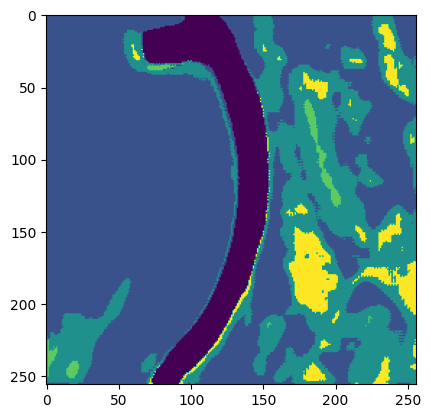

In [22]:
image=cv2.imread("image_part_001.jpg")
plt.imshow(prediction(image))